In [64]:
# 1. Register timeseries images to a reference image (img 1) (might not need to do that as we identify shoots in relation to the pot rim not the absolute position on the image)
# 2. Identify circle (which is the pot rim) (HoughCircles algorithm)
# 3. Segment out the individual shoots
# 4. Ensure that the segmentation and image of the identified pot rim are of the same dimensions
# 5. Make sure the segmentations are continuous (dilution/opening/skeletonization)
# 6. If the end of the elongated polygon is within N pixels of the pot rim identify as an individual belonging to the pot
# 7. Divide into sectors and associate each individual that starts within a sector as a unique individual belonging to the pot

In [65]:
import cv2
import glob

def load_image_timeseries(experiment_number, block_number, pot_number):
    # Define the base path for the images
    base_path = f"../datasets/niab/EXP{experiment_number:02d}/Top_Images/Top_Images_Clean_Rename/EXP{experiment_number:02d}_Block{block_number:02d}/"

    # Use glob to get all the image file paths
    image_paths = glob.glob(base_path + f"EXP{experiment_number:02d}_Block{block_number:02d}_Rename*/Exp{experiment_number:02d}_Block{block_number:02d}_Image*_Pot{pot_number:03d}.jpg")

    # Sort the paths to ensure they are in the correct order
    image_paths.sort()

    # Load the images into OpenCV
    images = [cv2.imread(path) for path in image_paths]

    return images

images = load_image_timeseries(1, 1, 1)

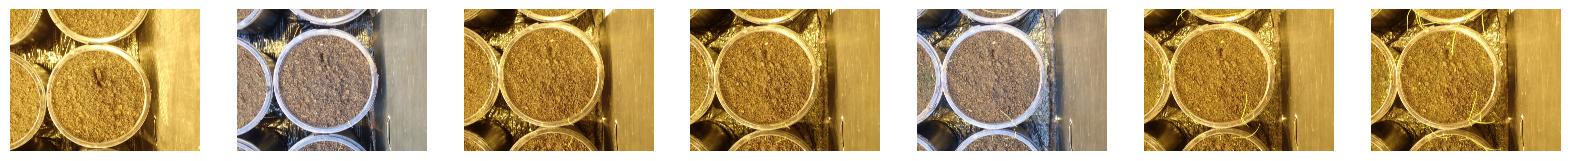

In [66]:
# Plot matrix of images in time series
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, len(images), figsize=(20, 20))
for i, image in enumerate(images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

plt.show()

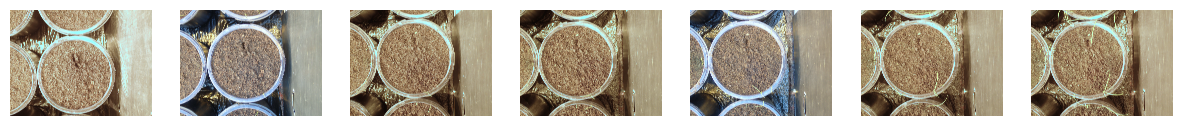

In [67]:
# white balance all images to make them more similar
def white_balance(image):
    result = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

images = [white_balance(image) for image in images]

# Plot matrix of images in time series
fig, ax = plt.subplots(1, len(images), figsize=(15, 15))
for i, image in enumerate(images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

Shift in x: 0, Shift in y: 365


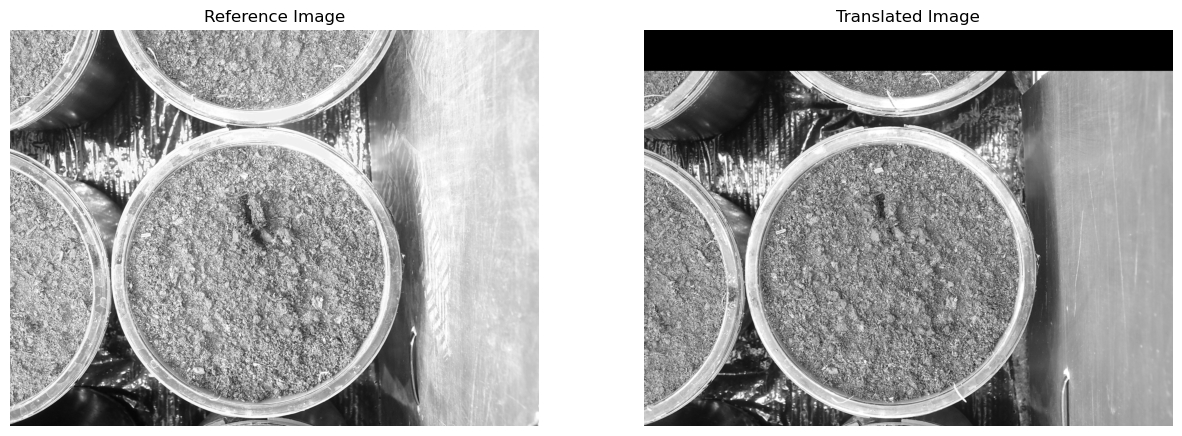

In [68]:
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images]

ref_img = images_gray[0]
img = images_gray[1]

def compute_translation(reference_image, image):
    f1 = np.fft.fft2(reference_image)
    f2 = np.fft.fft2(image)

    # Compute the Cross-Power Spectrum
    cross_power_spectrum = f1 * np.conj(f2)
    cross_power_spectrum /= np.abs(cross_power_spectrum)

    # Compute the Inverse Fourier Transform
    shift = np.fft.ifft2(cross_power_spectrum).real

    # Find the peak location
    shift_y, shift_x = np.unravel_index(np.argmax(shift), shift.shape)

    print(f"Shift in x: {shift_x}, Shift in y: {shift_y}")

    return shift_x, shift_y

def align_images(image, shift_x, shift_y):
    # Create the translation matrix
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])

    # Translate the image
    return cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))

x_translate, y_translate = compute_translation(ref_img, img)
img = align_images(img, x_translate, y_translate)

# Display the images side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(ref_img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Reference Image')

ax[1].imshow(img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Translated Image')

plt.show()

# Seems to work fantastically on the first two images but on none of the others (can ommit this step as we are identifying shoots in relation to the pot rim not the absolute position on the image)

Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)
Original Dimensions: (3456, 4608, 3)
New Dimensions: (460, 345)


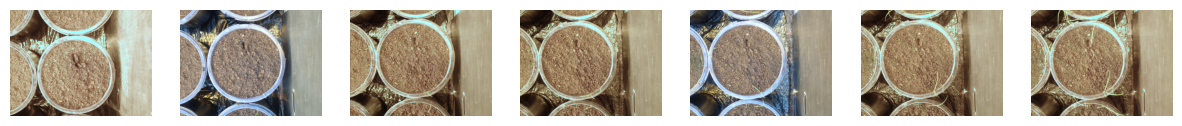

In [79]:
# Reduce the resolution of the images to speed up the Hough Circle detection
def reduce_resolution(image, scale_percent=10):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    print(f"Original Dimensions: {image.shape}")
    print(f"New Dimensions: {dim}")

    return cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

smaller_images = [reduce_resolution(image) for image in images]

# Plot matrix of images in time series
fig, ax = plt.subplots(1, len(smaller_images), figsize=(15, 15))
for i, image in enumerate(smaller_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

1
1
1
1
1
1
1


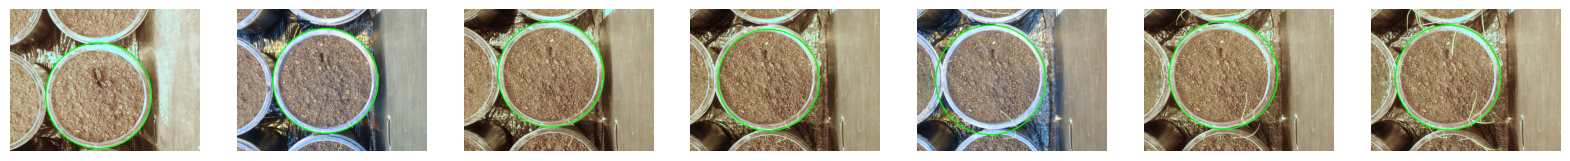

In [80]:
# for each small_image identify the pot rim
small_grey_imgs = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in smaller_images]

for i, img in enumerate(small_grey_imgs):
    circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100, param1=50, param2=30, minRadius=120, maxRadius=135)

    if circles is not None:
        print(len(circles[0]))
        circles = np.uint16(np.around(circles))
        for circle in circles[0, :]:
            center = (circle[0], circle[1])
            radius = circle[2]
            cv2.circle(smaller_images[i], center, radius, (0, 255, 0), 2)

# Plot matrix of images in time series
fig, ax = plt.subplots(1, len(smaller_images), figsize=(20, 20))
for i, image in enumerate(smaller_images):
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')